#  Policy Gradient Method on CartPole using REINFORCE

##  Objective

Implement a **basic policy gradient method** (REINFORCE algorithm) using PyTorch to solve the `CartPole-v1` environment from OpenAI Gymnasium.

---

##  Background

Policy Gradient methods directly optimize the policy function $\pi_\theta(a|s)$ by maximizing the expected return using gradient ascent:

$$
\nabla_\theta J(\theta) = \mathbb{E}_{\pi_\theta} \left[ \nabla_\theta \log \pi_\theta(a|s) \cdot R \right]
$$

The REINFORCE algorithm updates the policy by following the gradient of the log-probabilities of actions taken, scaled by the return obtained from that trajectory.

---

##  Method: REINFORCE

### 1. **Policy Network**

- A simple 2-layer feedforward neural network with a softmax output layer
- Outputs action probabilities given a state

### 2. **Environment**

- `CartPole-v1` from `gymnasium`
- State: 4-dimensional vector
- Action: Discrete (Left or Right)

### 3. **Training Loop**

- For each episode:
  - Sample actions using the policy
  - Store log-probabilities and rewards
  - Calculate discounted returns
  - Compute loss: $-\sum \log \pi(a_t|s_t) \cdot G_t$
  - Backpropagate and update the policy

---

##  Key Implementation Steps

1. **Collect trajectory**: $(s_t, a_t, r_t)$
2. **Compute discounted returns**:

$$
G_t = \sum_{k=0}^{T-t} \gamma^k r_{t+k}
$$

3. **Normalize returns** (optional but improves stability)
4. **Update policy** using gradient ascent via PyTorch

---

##  Results

- The agent learns to balance the pole over episodes
- Rewards per episode increase steadily, reaching close to the maximum score of 500 (CartPole-v1 max length)
- Demonstrates that **basic policy gradient** methods can solve simple environments like CartPole without value functions

---

##  Limitations

- High variance in updates
- No baseline to subtract from returns
- Does not generalize well to more complex environments

These issues can be addressed with:
- Baseline (e.g., value function)
- Actor-Critic methods
- Generalized Advantage Estimation (GAE)

---

##  Conclusion

This notebook successfully implements the **REINFORCE algorithm**, meeting the objective of applying a basic **policy gradient method** on the **CartPole** task. It showcases the core idea behind policy gradient reinforcement learning.


In [1]:
!pip uninstall -y gym
!pip install gymnasium[classic-control] numpy matplotlib torch --quiet


Found existing installation: gym 0.25.2
Uninstalling gym-0.25.2:
  Successfully uninstalled gym-0.25.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.7 MB/s eta 0:00:00


Episode 0, Reward: 17.0
Episode 50, Reward: 49.0
Episode 100, Reward: 14.0
Episode 150, Reward: 207.0
Episode 200, Reward: 500.0
Episode 250, Reward: 500.0
Episode 300, Reward: 500.0
Episode 350, Reward: 500.0
Episode 400, Reward: 500.0
Episode 450, Reward: 500.0
Episode 500, Reward: 405.0
Episode 550, Reward: 500.0
Episode 600, Reward: 500.0
Episode 650, Reward: 500.0
Episode 700, Reward: 21.0
Episode 750, Reward: 121.0
Episode 800, Reward: 18.0
Episode 850, Reward: 27.0
Episode 900, Reward: 54.0
Episode 950, Reward: 87.0


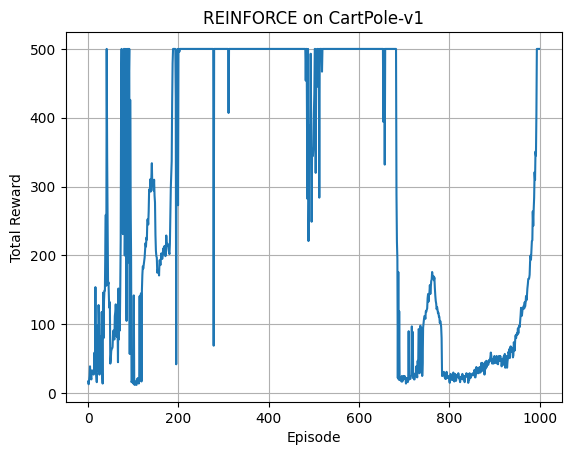

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import gymnasium as gym
import matplotlib.pyplot as plt

# Policy Network
class PolicyNet(nn.Module):
    def __init__(self, state_size=4, hidden=128, action_size=2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_size, hidden),
            nn.ReLU(),
            nn.Linear(hidden, action_size),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.model(x)

# Discounted rewards
def compute_discounted_rewards(rewards, gamma=0.99):
    discounted = []
    R = 0
    for r in reversed(rewards):
        R = r + gamma * R
        discounted.insert(0, R)
    return torch.tensor(discounted, dtype=torch.float32)

# Environment
env = gym.make("CartPole-v1", render_mode=None)
policy = PolicyNet()
optimizer = optim.Adam(policy.parameters(), lr=1e-2)
num_episodes = 1000
gamma = 0.99
reward_history = []

for episode in range(num_episodes):
    state, _ = env.reset()
    log_probs = []
    rewards = []
    done = False

    while not done:
        state_tensor = torch.tensor(state, dtype=torch.float32)
        probs = policy(state_tensor)
        dist = Categorical(probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)

        next_state, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated

        log_probs.append(log_prob)
        rewards.append(reward)
        state = next_state

    # REINFORCE update
    discounted = compute_discounted_rewards(rewards, gamma)
    advantages = (discounted - discounted.mean()) / (discounted.std() + 1e-9)
    loss = -torch.stack([lp * adv for lp, adv in zip(log_probs, advantages)]).sum()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    reward_history.append(sum(rewards))
    if episode % 50 == 0:
        print(f"Episode {episode}, Reward: {sum(rewards)}")

# Plotting
plt.plot(reward_history)
plt.title("REINFORCE on CartPole-v1")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()
